In [1]:
# Step 1: Define constants

import numpy as np
from torch.nn import CrossEntropyLoss, NLLLoss

# Run specific
DATASET = "mnist" # "mnist", "fashion-mnist", "cifar"
EPOCHS = 15
QUBITS = 4
SIMPLE_NEURONS_PER_FEATURE_PER_ROW = 8
LOSS_FUNC = NLLLoss()
PERTURB = False
RESUME_TRAINING = True
CHOOSE_NEW_RECEPTIVE_FIELDS = False
CHOOSE_NEW_TRAINING_DATA = False
RUN = "1"
# Constants
QC_REPETITIONS = 1
CLASSES = 4
BATCH_SIZE = 256
FEATURE_BRIGHTNESS = 2
FEATURE_ANGLES = 2
FEATURE_FREQUENCIES = 1

#For dynamic kernels
KERNEL="dynamic"
MIN_KERNEL_SIZE = 5
MIN_KERNEL_SIZE_GABOR = 2

#Derived:
TOTAL_FEATURES_PER_SITE = FEATURE_BRIGHTNESS + FEATURE_ANGLES * FEATURE_FREQUENCIES * 2
TOTAL_FEATURES = SIMPLE_NEURONS_PER_FEATURE_PER_ROW * SIMPLE_NEURONS_PER_FEATURE_PER_ROW * TOTAL_FEATURES_PER_SITE

FILENAME_PREFIX = f'v3-{DATASET}-r{RUN}-q{QUBITS}-{QC_REPETITIONS}-c{CLASSES}-n{TOTAL_FEATURES}-k{KERNEL}'
COMMON_FILENAME_PREFIX = f'v3-{DATASET}-r{RUN}-n{TOTAL_FEATURES}-k{KERNEL}'

if DATASET == "cifar":
  IMAGE_WIDTH = 32
  TARGETS = np.array(["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"])  
elif DATASET == "fashion-mnist":
  IMAGE_WIDTH = 28
  TARGETS = np.array(["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]) 
else: 
  IMAGE_WIDTH = 28
  TARGETS = np.array([0,1,2,3,4,5,6,7,8,9])


## Settings
DEBUG = False
SAMPLE_RUN = False
SAMPLE_ITERATIONS = 10


In [2]:
# Step 2: Necessary imports

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from itertools import cycle
import random
import os.path as path
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
from datetime import datetime

# Additional torch-related imports
import torch
from torch import Tensor, cat, no_grad, manual_seed
from torch.nn import Linear, MSELoss, Softmax
from torch.optim import LBFGS
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Bilinear,
    Dropout2d,
    MaxPool2d,
    Flatten,
    Sequential,
    ReLU,
)
import torch.nn.functional as F

# Project specific imports
from canonicallayers.brightnessextractor import extractBrightness, extractBrightnessAt
from canonicallayers.gaborfilterextractor import extract_power_feats
from canonicallayers.perturbations import skew, rotate, noise, elastic_transform
algorithm_globals.random_seed = 42

In [3]:
# Step 3: Prepare Training data
# -------------

train_loader = torch.load(f'checkpoints/{COMMON_FILENAME_PREFIX}-training.pt')
test_loader = torch.load(f'checkpoints/{COMMON_FILENAME_PREFIX}-testing.pt')


images shape torch.Size([256, 1, 28, 28])


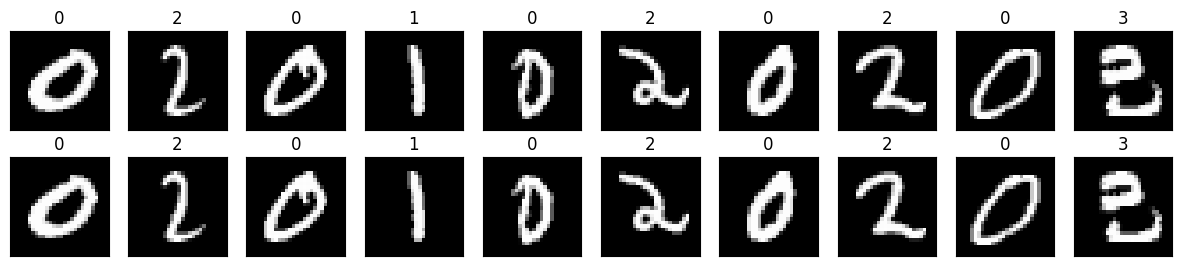

In [4]:
# Step 4 - Visualize dataset

n_samples_show = 10

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=2, ncols=n_samples_show, sharex=True, figsize=(15, 3))
images, targets = data_iter.__next__()
print("images shape", images.shape)

while n_samples_show > 0:
    originalImage = images[n_samples_show,0]
      
    if(PERTURB):
      perturbation = "none"
      match random.randint(0, 3):
          case 0:
            perturbedImage = skew(originalImage.numpy())
            perturbation = "skew"
          case 1:
            angle = 3*np.random.random()/5
            perturbedImage = rotate(originalImage.numpy(), angle)
            perturbation = f"rotate {np.round(angle*180/np.pi)}°"
          case 2:
            perturbedImage = noise(originalImage.numpy())
            perturbation = "noise"
          case _:
            perturbedImage = elastic_transform(originalImage.numpy())
            perturbation = "elastic"
      perturbedData = torch.tensor(perturbedImage).unsqueeze(0).unsqueeze(0)

    axes[0,n_samples_show - 1].imshow(originalImage.numpy().squeeze(), cmap="gray")
    axes[0,n_samples_show - 1].set_xticks([])
    axes[0,n_samples_show - 1].set_yticks([])
    axes[0,n_samples_show - 1].set_title(TARGETS[targets[n_samples_show].item()])
    if(PERTURB):
      axes[1,n_samples_show - 1].imshow(perturbedData[0].numpy().squeeze(), cmap="gray")
      axes[1,n_samples_show - 1].set_xticks([])
      axes[1,n_samples_show - 1].set_yticks([])
      axes[1,n_samples_show - 1].set_title("{}".format(perturbation))
    else:
      axes[1,n_samples_show - 1].imshow(originalImage.numpy().squeeze(), cmap="gray")
      axes[1,n_samples_show - 1].set_xticks([])
      axes[1,n_samples_show - 1].set_yticks([])
      axes[1,n_samples_show - 1].set_title(TARGETS[targets[n_samples_show].item()])
      
    n_samples_show -= 1

In [5]:
# Step 6 - Setup Feature Extraction parameters

gaborReceptiveFields = torch.load(f"checkpoints/{COMMON_FILENAME_PREFIX}-gaborReceptiveFields.pt")
gaborKernels = torch.load(f"checkpoints/{COMMON_FILENAME_PREFIX}-gaborKernels.pt")
gaborAngleTunings = torch.load(f"checkpoints/{COMMON_FILENAME_PREFIX}-gaborAngleTunings.pt")
gaborFrequencyTunings = torch.load(f"checkpoints/{COMMON_FILENAME_PREFIX}-gaborFrequencyTunings.pt")


In [6]:
# Step 7- Define QNN Model

def parity(x):
    return x % CLASSES

# Define and create QNN
def create_qnn():
    feature_map = ZZFeatureMap(QUBITS, reps=QC_REPETITIONS)
    ansatz = RealAmplitudes(QUBITS, reps=1)
    qc = QuantumCircuit(QUBITS)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = SamplerQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
        interpret=parity,
        output_shape=CLASSES
    )
    return qnn


qnn4 = create_qnn()

In [7]:
# Step 8 - Feature extraction functions
dataWidth = SIMPLE_NEURONS_PER_FEATURE_PER_ROW
imgWidth = IMAGE_WIDTH - MIN_KERNEL_SIZE +1
gaborImgWidth = IMAGE_WIDTH - MIN_KERNEL_SIZE +1 # IMAGE_WIDTH - MIN_KERNEL_SIZE_GABOR +1


def extractFeatures(data, brightnessReceptiveFields, brightnessTunings, brightnessKernels, gaborReceptiveFields, gaborAngleTunings, gaborFrequencyTunings, gaborKernels):
  f = torch.zeros(data.shape[0],TOTAL_FEATURES_PER_SITE,SIMPLE_NEURONS_PER_FEATURE_PER_ROW,SIMPLE_NEURONS_PER_FEATURE_PER_ROW)
  # print("f", f.shape)
  #Fill Brigtness, orientation input
  for bi in range(0, data.shape[0]):
    for i in range(0, SIMPLE_NEURONS_PER_FEATURE_PER_ROW):
      for j in range(0,SIMPLE_NEURONS_PER_FEATURE_PER_ROW):
        featureIndex = 0
        brightnessSpot = brightnessReceptiveFields[i][j]
        brightnessKernelSize = brightnessKernels[i][j]

        for br in range(0, FEATURE_BRIGHTNESS):
          brightnessTuning = brightnessTunings[br][i][j]
          b = extractBrightnessAt(data[bi].unsqueeze(0), brightnessTuning, brightnessSpot//imgWidth, brightnessSpot%imgWidth, brightnessKernelSize)
          f[bi][featureIndex][i][j] = b
          featureIndex += 1
        
        gaborSpot = gaborReceptiveFields[i][j].item()
        gaborKernelSize = gaborKernels[i][j].item()

        for an in range(0, FEATURE_ANGLES):
          for fr in range(0, FEATURE_FREQUENCIES):
            gaborFrequency = gaborFrequencyTunings[fr][i][j].item()
            gaborAngle = gaborAngleTunings[an][i][j].item()
            kernel, power_feats, power_img = extract_power_feats(data[bi].unsqueeze(0), gaborKernelSize, gaborSpot//gaborImgWidth, gaborSpot%gaborImgWidth, gaborFrequency, gaborAngle)
            f[bi][featureIndex][i][j] = power_feats[0]
            f[bi][featureIndex+1][i][j] = power_feats[1]
            featureIndex += 2
  return f

In [8]:
gaborReceptiveFields = torch.load(f"checkpoints/{COMMON_FILENAME_PREFIX}-gaborReceptiveFields.pt")
gaborKernels = torch.load(f"checkpoints/{COMMON_FILENAME_PREFIX}-gaborKernels.pt")
gaborAngleTunings = torch.load(f"checkpoints/{COMMON_FILENAME_PREFIX}-gaborAngleTunings.pt")
gaborFrequencyTunings = torch.load(f"checkpoints/{COMMON_FILENAME_PREFIX}-gaborFrequencyTunings.pt")
gaborBrightnessTunings = torch.load(f"checkpoints/{COMMON_FILENAME_PREFIX}-gaborBrightnessTunings.pt")

In [10]:
for batch_idx, (data, target) in enumerate(train_loader):
  print("input", batch_idx, data.shape)
  x = extractFeatures(data, gaborReceptiveFields, gaborBrightnessTunings, gaborKernels, gaborReceptiveFields, gaborAngleTunings, gaborFrequencyTunings, gaborKernels)
  print("features", x.shape)
  break

input 0 torch.Size([256, 1, 28, 28])
features torch.Size([256, 6, 8, 8])


In [27]:
data_iter = iter(train_loader)
images, targets = data_iter.__next__()
print("images shape", images.shape, "gaborReceptiveFields", gaborReceptiveFields.shape, gaborBrightnessTunings.shape, gaborKernels.shape)
print("Brightness", gaborBrightnessTunings)
print("angles", gaborAngleTunings)
x = extractFeatures(images, gaborReceptiveFields, gaborBrightnessTunings, gaborKernels, gaborReceptiveFields, gaborAngleTunings, gaborFrequencyTunings, gaborKernels)


images shape torch.Size([256, 1, 28, 28]) gaborReceptiveFields torch.Size([8, 8]) torch.Size([2, 8, 8]) torch.Size([8, 8])
Brightness tensor([[[0.0815, 0.8470, 0.4404, 0.2472, 0.3846, 0.5267, 0.1344, 0.0191],
         [0.1717, 0.8963, 0.6450, 0.0023, 0.2307, 0.8792, 0.9796, 0.5994],
         [0.7780, 0.5824, 0.7910, 0.1091, 0.5840, 0.0567, 0.0082, 0.9203],
         [0.5484, 0.7093, 0.4331, 0.0870, 0.8797, 0.0449, 0.1720, 0.6611],
         [0.3143, 0.6348, 0.0391, 0.6876, 0.1697, 0.7776, 0.4446, 0.0947],
         [0.3807, 0.4165, 0.8108, 0.2782, 0.5444, 0.2756, 0.5173, 0.9388],
         [0.7151, 0.6072, 0.0440, 0.7925, 0.9813, 0.6271, 0.9159, 0.7196],
         [0.9693, 0.4357, 0.3235, 0.7600, 0.3658, 0.4529, 0.4373, 0.3173]],

        [[0.5925, 0.4004, 0.1755, 0.9584, 0.0238, 0.2352, 0.9578, 0.1915],
         [0.0701, 0.7896, 0.9866, 0.8582, 0.1541, 0.0129, 0.0521, 0.4837],
         [0.6199, 0.4895, 0.6354, 0.2771, 0.5011, 0.9488, 0.3370, 0.1258],
         [0.9354, 0.8343, 0.9632, 0.915

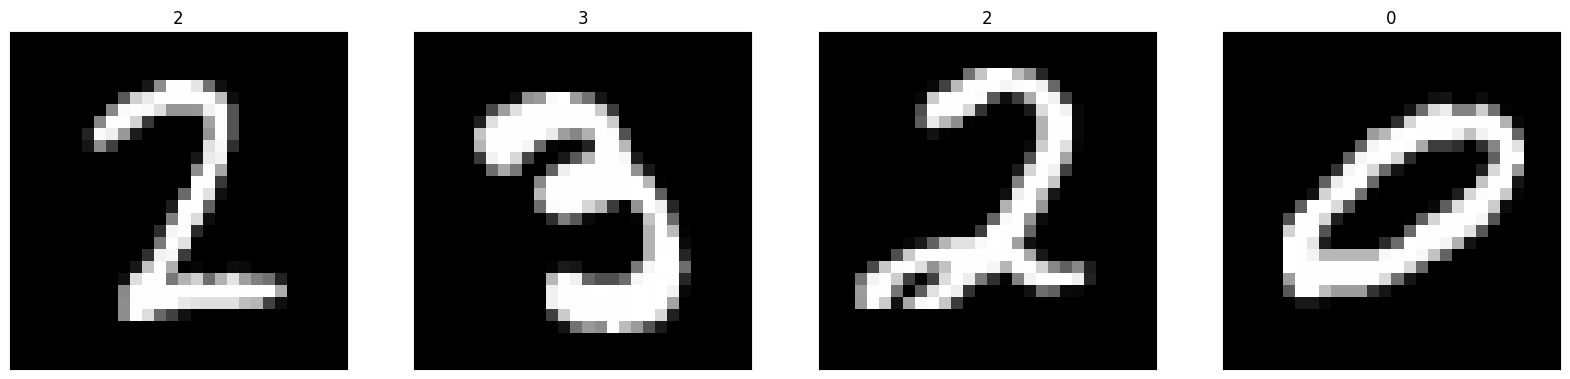

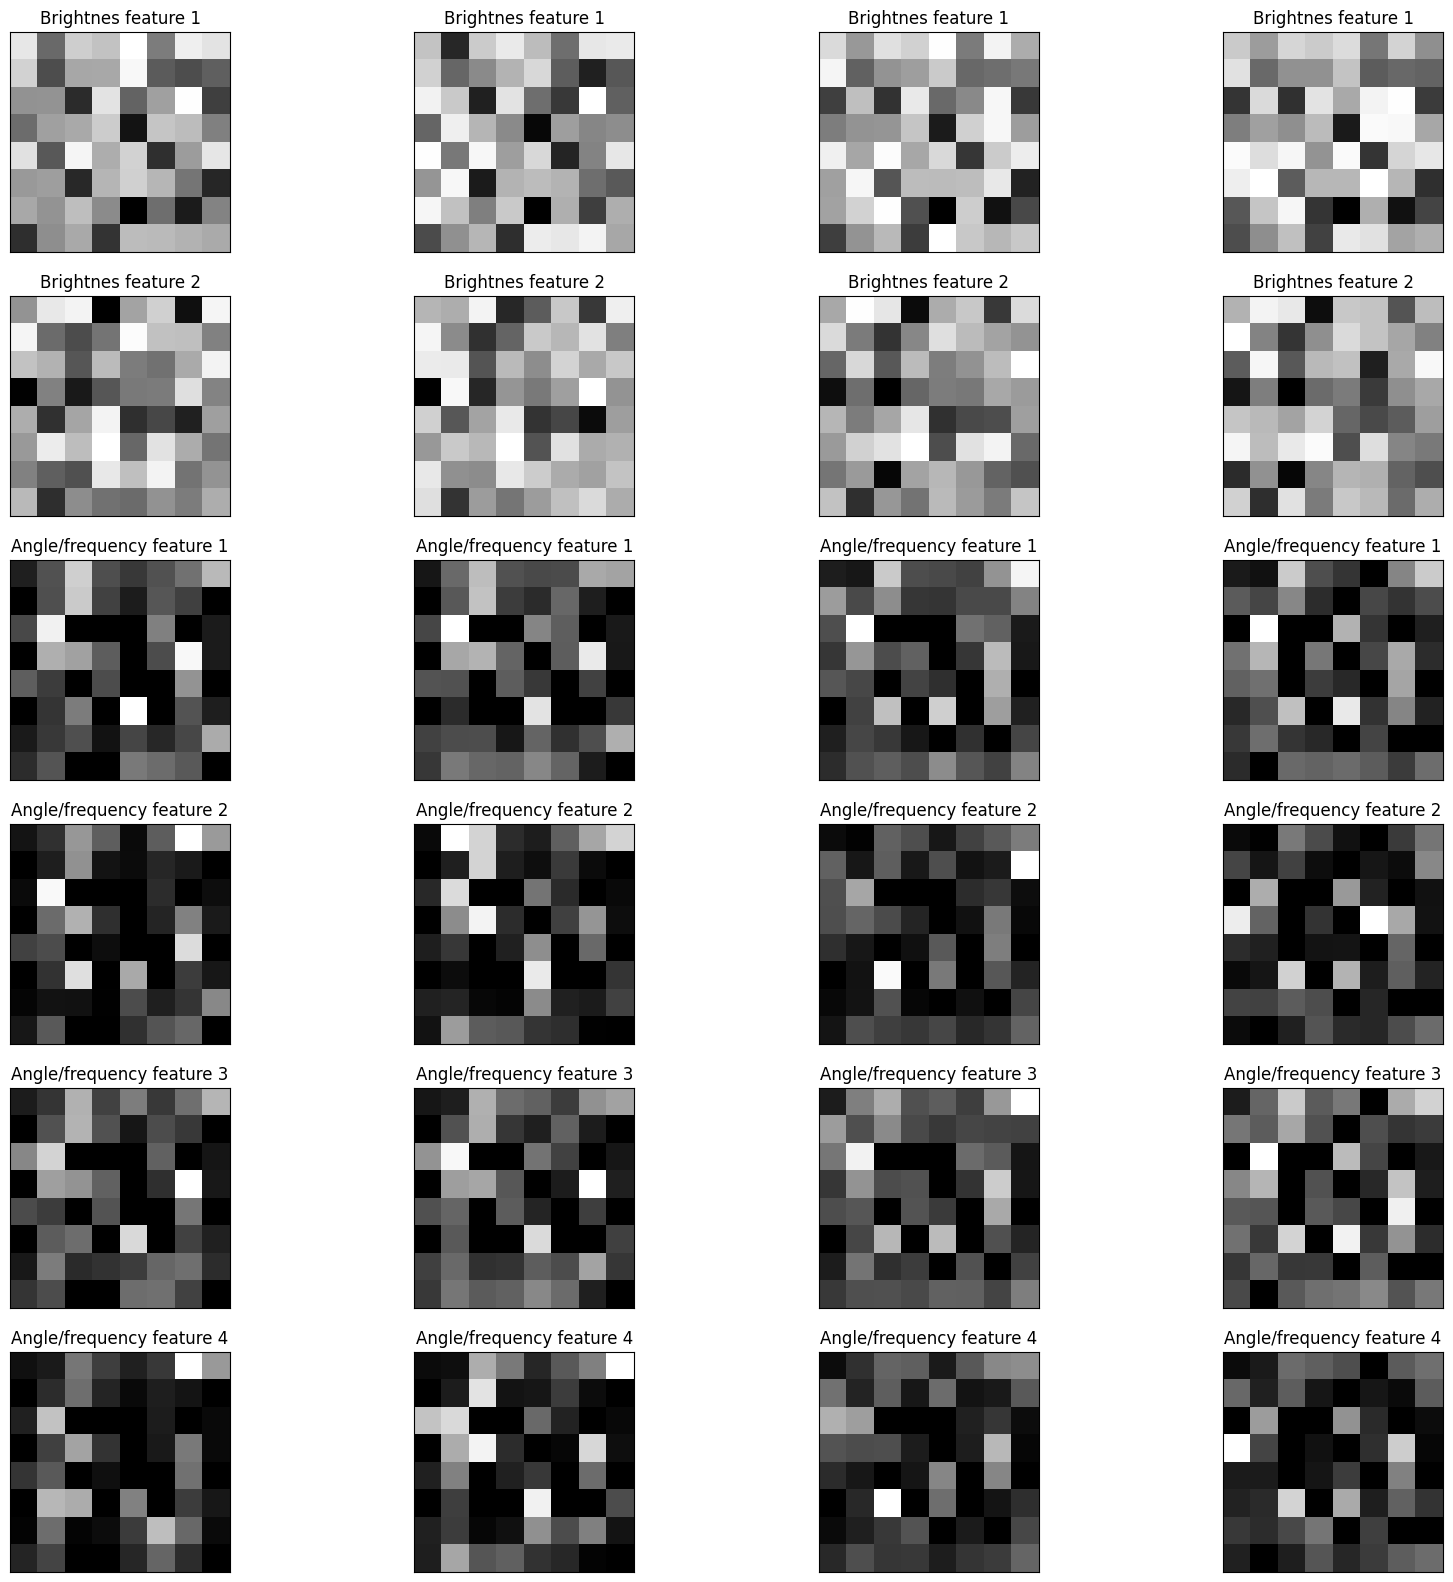

In [26]:
# Step 4 - Visualize dataset

n_samples_show = 4
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, sharex=True, figsize=(20, 20))
fig2, axes2 = plt.subplots(nrows=6, ncols=n_samples_show, sharex=True, figsize=(20, 20))

while n_samples_show > 0:
  originalImage = images[n_samples_show,0]

  axes[n_samples_show - 1].imshow(originalImage.numpy().squeeze(), cmap="gray")
  axes[n_samples_show - 1].set_xticks([])
  axes[n_samples_show - 1].set_yticks([])
  axes[n_samples_show - 1].set_title(TARGETS[targets[n_samples_show].item()])
  for a in range(6):
    features = x[n_samples_show, a]
    axes2[a,n_samples_show - 1].imshow(features.numpy().squeeze(), cmap="gray")
    axes2[a,n_samples_show - 1].set_xticks([])
    axes2[a,n_samples_show - 1].set_yticks([])
    if(a<=1):
      axes2[a,n_samples_show - 1].set_title("Brightnes feature {}".format(a+1))
    else:
      axes2[a,n_samples_show - 1].set_title("Angle/frequency feature {}".format(a-1))
  n_samples_show -= 1